In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import torch
torch.__version__

'2.1.2'

In [3]:
torch.cuda.is_available()

True

In [4]:
import warnings
warnings.filterwarnings("ignore")


In [5]:
import gc
import random
import numpy as np
import pandas as pd
from IPython.display import display

In [6]:
import timm
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.optim.lr_scheduler import CosineAnnealingLR

In [7]:
import torchvision.transforms as transforms

In [8]:
gc.collect()

16

In [9]:
class Config:
    seed = 42
    image_transform = transforms.Resize((214, 214)) # resent34's input size
    batch_size = 16
    num_epochs = 10

In [10]:
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = True
torch.manual_seed(Config.seed)
np.random.seed(Config.seed)
random.seed(Config.seed)

In [11]:
train_df = pd.read_csv("/kaggle/input/hms-harmful-brain-activity-classification/train.csv")
train_df.head()

,eeg_id,eeg_sub_id,eeg_label_offset_seconds,spectrogram_id,spectrogram_sub_id,spectrogram_label_offset_seconds,label_id,patient_id,expert_consensus,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,other_vote
0,1628180742,0,0.0,353733,0,0.0,127492639,42516,Seizure,3,0,0,0,0,0
1,1628180742,1,6.0,353733,1,6.0,3887563113,42516,Seizure,3,0,0,0,0,0
2,1628180742,2,8.0,353733,2,8.0,1142670488,42516,Seizure,3,0,0,0,0,0
3,1628180742,3,18.0,353733,3,18.0,2718991173,42516,Seizure,3,0,0,0,0,0
4,1628180742,4,24.0,353733,4,24.0,3080632009,42516,Seizure,3,0,0,0,0,0


In [12]:
train_df.spectrogram_id.nunique()

11138

In [13]:
labels = [label.lower() for label in train_df.expert_consensus.unique()]
labels

['seizure', 'gpd', 'lrda', 'other', 'grda', 'lpd']

In [14]:
target_df = pd.DataFrame()
for label in labels:
    grouped_by_spec = train_df[f"{label}_vote"].groupby(train_df.spectrogram_id).sum()
    temp_grouped_df = pd.DataFrame({"spectrogram_id" : grouped_by_spec.index,
                                    f"{label}_vote_sum" : grouped_by_spec.values})
    
    # first label
    if label == "seizure":
        target_df = temp_grouped_df
    else:
        target_df = target_df.merge(temp_grouped_df, on = "spectrogram_id", how = "left")

In [15]:
target_df.head()

,spectrogram_id,seizure_vote_sum,gpd_vote_sum,lrda_vote_sum,other_vote_sum,grda_vote_sum,lpd_vote_sum
0,353733,27,0,0,0,0,0
1,924234,0,10,0,10,2,0
2,999431,0,0,154,11,0,11
3,1084844,0,0,18,0,0,0
4,1219001,21,10,0,0,0,0


In [16]:
target_df.shape[0] == train_df.spectrogram_id.nunique()

True

In [17]:
# normalize
target_df["total_vote"] = 0
for label in labels:
    target_df["total_vote"] += target_df[f"{label}_vote_sum"]
target_df.head()

,spectrogram_id,seizure_vote_sum,gpd_vote_sum,lrda_vote_sum,other_vote_sum,grda_vote_sum,lpd_vote_sum,total_vote
0,353733,27,0,0,0,0,0,27
1,924234,0,10,0,10,2,0,22
2,999431,0,0,154,11,0,11,176
3,1084844,0,0,18,0,0,0,18
4,1219001,21,10,0,0,0,0,31


In [18]:
for label in labels:
    target_df[f"{label}_vote_sum"] = target_df[f"{label}_vote_sum"]/target_df.total_vote
    
target_df = target_df.drop("total_vote", axis = 1)
target_df.head()

,spectrogram_id,seizure_vote_sum,gpd_vote_sum,lrda_vote_sum,other_vote_sum,grda_vote_sum,lpd_vote_sum
0,353733,1.000000,0.000000,0.000,0.000000,0.000000,0.0000
1,924234,0.000000,0.454545,0.000,0.454545,0.090909,0.0000
2,999431,0.000000,0.000000,0.875,0.062500,0.000000,0.0625
3,1084844,0.000000,0.000000,1.000,0.000000,0.000000,0.0000
4,1219001,0.677419,0.322581,0.000,0.000000,0.000000,0.0000


In [19]:
target_df["path"] = target_df["spectrogram_id"].apply(lambda x: "/kaggle/input/hms-harmful-brain-activity-classification/train_spectrograms/" + str(x) + ".parquet")
target_df.head()

,spectrogram_id,seizure_vote_sum,gpd_vote_sum,lrda_vote_sum,other_vote_sum,grda_vote_sum,lpd_vote_sum,path
0,353733,1.000000,0.000000,0.000,0.000000,0.000000,0.0000,/kaggle/input/hms-harmful-brain-activity-class...
1,924234,0.000000,0.454545,0.000,0.454545,0.090909,0.0000,/kaggle/input/hms-harmful-brain-activity-class...
2,999431,0.000000,0.000000,0.875,0.062500,0.000000,0.0625,/kaggle/input/hms-harmful-brain-activity-class...
3,1084844,0.000000,0.000000,1.000,0.000000,0.000000,0.0000,/kaggle/input/hms-harmful-brain-activity-class...
4,1219001,0.677419,0.322581,0.000,0.000000,0.000000,0.0000,/kaggle/input/hms-harmful-brain-activity-class...


In [20]:
pd.read_parquet(target_df["path"][0]).head()

,time,LL_0.59,LL_0.78,LL_0.98,LL_1.17,LL_1.37,LL_1.56,LL_1.76,LL_1.95,LL_2.15,...,RP_18.16,RP_18.36,RP_18.55,RP_18.75,RP_18.95,RP_19.14,RP_19.34,RP_19.53,RP_19.73,RP_19.92
0,1,4.26,10.98,9.05,13.65,11.49,8.930000,18.840000,19.26,19.240000,...,0.31,0.17,0.28,0.19,0.24,0.27,0.29,0.16,0.22,0.19
1,3,2.65,3.97,12.18,13.26,14.21,13.230000,9.650000,8.11,11.280000,...,0.15,0.13,0.14,0.24,0.24,0.36,0.35,0.31,0.36,0.40
2,5,4.18,4.53,8.77,14.26,13.36,16.559999,19.219999,17.51,22.650000,...,0.29,0.21,0.16,0.25,0.28,0.28,0.34,0.48,0.44,0.48
3,7,2.41,3.21,4.92,8.07,5.97,12.420000,10.820000,14.96,21.809999,...,0.33,0.51,0.49,0.64,0.58,0.42,0.32,0.31,0.32,0.33
4,9,2.29,2.44,2.77,4.62,5.39,7.080000,9.840000,12.27,14.410000,...,0.44,0.38,0.48,0.63,0.45,0.45,0.49,0.33,0.31,0.34


In [21]:
import matplotlib.pyplot as plt 
def plot_spectogram(path):
    target = pd.read_parquet(path)
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 12))
    axes = axes.flatten()
    
    target = {
        "LL": target.filter(regex='^LL', axis=1),
        "RL": target.filter(regex='^RL', axis=1),
        "RP": target.filter(regex='^RP', axis=1),
        "LP": target.filter(regex='^LP', axis=1)}
    
    #print(target["LL"].head())
    
    for i, label in enumerate(target.keys()):
        # select the subplot
        ax = axes[i]
        # plot the class columns
        """
            In the context of plotting spectrogram data, where the columns represent 
            different time points and the rows represent different frequency bins, 
            transposing the DataFrame allows to correctly align the time and frequency 
            axes with the axes of the plot.
            This adjustment is often necessary because the default orientation of 
            imshow() considers the first axis (axis 0) as the vertical axis and 
            the second axis (axis 1) as the horizontal axis.
        """
        img = ax.imshow(np.log(target[label]).T, cmap='viridis', aspect='auto', origin='lower')
                        
    plt.tight_layout()
    plt.show()

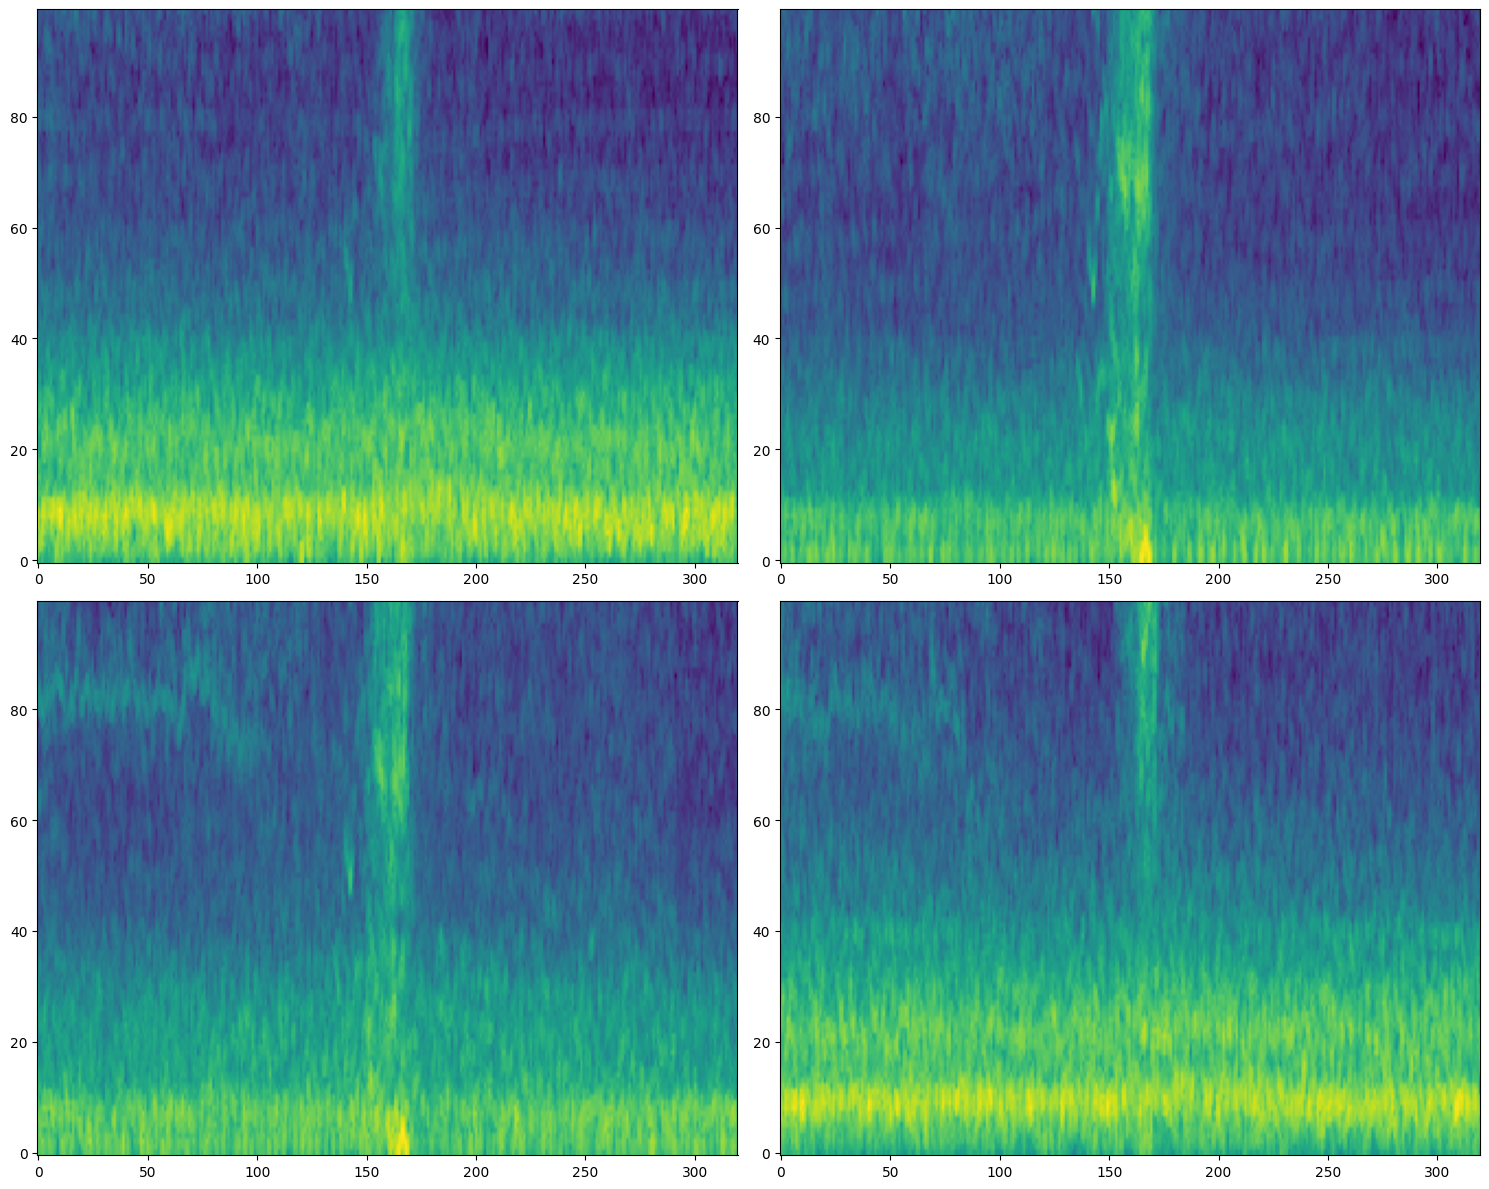

In [22]:
plot_spectogram(target_df["path"][0])

In [23]:
target_df[["path"]].iloc[0].values

array(['/kaggle/input/hms-harmful-brain-activity-classification/train_spectrograms/353733.parquet'],
      dtype=object)

In [24]:
target_df["path"].iloc[0]

'/kaggle/input/hms-harmful-brain-activity-classification/train_spectrograms/353733.parquet'

In [25]:
def get_data(paths):
    eps = 1e-6 # incase data_std returns 0
    batch_data = []
    for path in paths:
        data = pd.read_parquet(path[0])
        data = data.fillna(-1).values[:, 1:].T
        data = np.clip(data, np.exp(-6), np.exp(10))
        data = np.log(data)
        
        data_mean = data.mean(axis=(0, 1))
        data_std = data.std(axis=(0, 1))
        data = (data - data_mean) / (data_std + eps)
        
        data_tensor = torch.unsqueeze(torch.Tensor(data), dim=0)
        data = Config.image_transform(data_tensor)
        
        batch_data.append(data)
        
    return torch.stack(batch_data)

In [26]:
# def get_data(paths, batch_size=Config.batch_size):
#     # Set a small epsilon to avoid division by zero
#     eps = 1e-6

#     # Initialize a list to store batch data
#     batch_data = []

#     # Iterate over each path in the provided paths
#     for path in paths:
#         # Read data from parquet file
#         data = pd.read_parquet(path[0])

#         # Fill missing values, remove time column, and transpose
#         data = data.fillna(-1).values[:, 1:].T

#         # Clip values and apply logarithmic transformation
#         data = np.clip(data, np.exp(-6), np.exp(10))
#         data = np.log(data)

#         # Normalize the data
#         data_mean = data.mean(axis=(0, 1))
#         data_std = data.std(axis=(0, 1))
#         data = (data - data_mean) / (data_std + eps)

#         # Convert data to a PyTorch tensor and apply transformations
#         data_tensor = torch.unsqueeze(torch.Tensor(data), dim=0)
#         data = Config.image_transform(data_tensor)

#         # Append the processed data to the batch_data list
#         batch_data.append(data)

#     # Stack all the batch data into a single tensor
#     batch_data = torch.stack(batch_data)

#     # Return the batch data
#     return batch_data

In [27]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


In [28]:
from torch import tensor
from torchmetrics.regression import KLDivergence
p = tensor([[0.36, 0.48, 0.16]])
q = tensor([[1/3, 1/3, 1/3]])
kl_divergence = KLDivergence()
kl_divergence(p, q)

tensor(0.0853)

following https://www.kaggle.com/code/andreasbis/hms-train-resnet34d/notebook

In [29]:
    model = timm.create_model('resnet34d', pretrained=True, num_classes=6, in_chans=1)
    model.to(device)

    optimizer = optim.AdamW(model.parameters(), lr=0.001, betas=(0.5, 0.999), weight_decay=0.01)
    scheduler = CosineAnnealingLR(optimizer, T_max=Config.num_epochs)

    best_test_loss = float('inf')
    train_losses = []
    test_losses = []

model.safetensors:   0%|          | 0.00/87.4M [00:00<?, ?B/s]

In [30]:
train_idx = np.arange(int(len(target_df)* 0.8))
np.random.shuffle(train_idx)

In [31]:
train_idx, train_idx.shape

(array([4575, 1488, 4970, ..., 5390,  860, 7270]), (8910,))

In [32]:
y_features = ["seizure_vote_sum", 
              "lpd_vote_sum", 
              "gpd_vote_sum", 
              "lrda_vote_sum", 
              "grda_vote_sum", 
              "other_vote_sum"]

In [33]:
def KL_loss(p,q):
    epsilon=10**(-15)
    p=torch.clip(p,epsilon,1-epsilon)
    q = nn.functional.log_softmax(q,dim=1)
    return torch.mean(torch.sum(p*(torch.log(p)-q),dim=1))

In [34]:
 for epoch in range(Config.num_epochs):
        print(f"Epoch - {epoch}")
        model.train()
        train_loss = []
        train_loss_plot = []
#         random_num = np.arange(len(train_idx))
#         np.random.shuffle(random_num)
#         train_idx = train_idx[random_num]

        # Iterate over batches in the training set
        for idx in range(0, len(train_idx), Config.batch_size):
            print(idx, end = "-")
            optimizer.zero_grad()
            train_idx1 = train_idx[idx:idx + Config.batch_size]
            train_X1_path = target_df[["path"]].iloc[train_idx1].values
            train_X1 = get_data(train_X1_path)
            print(f"train values from function {train_X1}")
            
            train_y1 = target_df[y_features].iloc[train_idx1].values
            train_y1 = torch.Tensor(train_y1)
            print(f"y values for probability {train_y1}")

            train_pred = model(train_X1.to(device))
            print(f"train pred {train_pred}")
            kl_divergence.to(device)
            
#             loss = KL_loss(train_y1.to(device), train_pred)
            loss = kl_divergence(train_y1.to(device), train_pred)
            print(f"loss value in tensor {loss}")
            loss.backward()
            optimizer.step()
            train_loss.append(loss.item())
            print(f"loss item {loss.item()}")
            
            break
        break

        epoch_train_loss = np.mean(train_loss)
        print(f"mean loss in the epoch {epoch_train_loss}")
        train_loss_plot.append(epoch_train_loss)
        print(f"Epoch {epoch + 1}: Train Loss = {epoch_train_loss:.2f}")

        scheduler.step()

gc.collect()

Epoch - 0
0-train values from function tensor([[[[ 3.3792e+00,  3.9925e+00,  2.6073e+00,  ...,  1.7435e+00,
            1.4221e+00,  1.3808e+00],
          [ 2.9397e+00,  3.9258e+00,  2.3127e+00,  ...,  1.7554e+00,
            1.1033e+00,  1.3442e+00],
          [ 2.2618e+00,  3.7257e+00,  1.8244e+00,  ...,  1.6147e+00,
            7.6881e-01,  9.7392e-01],
          ...,
          [ 2.7816e-01,  3.7997e-01, -2.4934e-01,  ...,  1.4106e-01,
           -3.9760e-01, -5.9486e-01],
          [ 2.0649e-01,  5.1185e-01, -4.1813e-01,  ...,  1.0741e-01,
           -4.4135e-01, -4.1950e-01],
          [ 1.3213e-01,  4.3533e-01, -3.8227e-01,  ..., -2.5847e-03,
           -3.8458e-01, -3.7676e-01]]],


        [[[ 2.0387e+00,  1.9308e+00,  1.2621e+00,  ...,  2.2888e+00,
            2.1330e+00,  2.1271e+00],
          [ 2.2019e+00,  2.2097e+00,  1.6387e+00,  ...,  2.2532e+00,
            2.1460e+00,  2.2710e+00],
          [ 2.0449e+00,  2.1205e+00,  1.7485e+00,  ...,  2.0050e+00,
            2.001

12707